### 06 - Qualitative analysis - exp_003 and exp_005

exp_003: visual ON and position ON

exp_005: visual OFF and position OFF

We define two situations:

- situation 1: exp_003 prediction = 1 and exp_005 prediction = 0<br>
- situation 2: exp_003 prediction = 1 and exp_005 prediction = 1


##### Hyps:

- 1A: the predicted bbox in exp_005 was too hard to describe using the existing text.

- 2A: the text for describing the bbox ground truth is overspescified.

In [1]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from torchvision.ops import box_iou

from rec.utils import draw_bounding_boxes

pd.set_option('display.max_colwidth', None)

/home/nhormann/miniconda3/envs/rec-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BASE_PATH = "../code/rec/"

In [3]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, max(im1.height, im2.height)))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


def get_iou_column(df, bbox_pred_colname="bbox_pred"):
    df.loc[:, "bbox_raw"] = df.bbox_raw.apply(lambda v: np.resize(v, (1, 4)))
    df.loc[:, bbox_pred_colname] = df[bbox_pred_colname].apply(lambda v: np.resize(v, (1, 4)))
    df.loc[:, "iou"] = df.apply(lambda row: box_iou(torch.from_numpy(row[bbox_pred_colname]),
                                                    torch.from_numpy(row["bbox_raw"])), axis=1)
    df = df.astype({"iou": float})
    return df

### Read validation data from all available experiments results

In [4]:
exp_d = {
    "exp_003": [
        ["exp_003", "predictions_val.parquet", True, True],
    ],
    "exp_005": [
        ["exp_005", "predictions_val_2023_11_05_23_58.parquet", False, False],
    ],
}
exp_descriptions = {
    "exp_003": "Exp from the section 3.1 of the paper.",
    "exp_005": "Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding OFF.",
}

In [5]:
df_preds_list = []
for exp_base, lst_exps in exp_d.items():
    exp_base_description = exp_descriptions[exp_base]
    for exp_number, exp_filename, use_visual_pos_emb, use_visual_emb in lst_exps:
        df = pd.read_parquet(f"../models/{exp_number}/{exp_filename}")
        df.loc[:, "exp_number"] = exp_number
        df.loc[:, "exp_description"] = exp_base_description
        df = get_iou_column(df)
        df = df.rename(columns={"hits": "hits_50"})
        df_preds_list.append(df)
df_preds_val = pd.concat(df_preds_list, ignore_index=True)

In [6]:
df_preds_val.head()

,bbox_raw,bbox_pred,img_filename,expr,hits_50,spatial,ordinal,relational,intrinsic,exp_number,exp_description,iou
0,"[[156.0, 169.0, 224.0, 360.0]]","[[151.18057, 165.33563, 211.10284, 359.0]]",refer/data/images/saiapr_tc-12/10/images/10890.jpg,person on the left,1.0,1,0,0,0,exp_003,Exp from the section 3.1 of the paper.,0.741297
1,"[[0.0, 94.0, 480.0, 360.0]]","[[19.449877, 49.38504, 479.0, 359.0]]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,the trees,1.0,0,0,0,1,exp_003,Exp from the section 3.1 of the paper.,0.821828
2,"[[110.0, 64.0, 296.0, 183.0]]","[[43.807602, 8.283485, 277.42676, 169.42986]]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,sky next to clouds,0.0,1,0,1,0,exp_003,Exp from the section 3.1 of the paper.,0.418993
3,"[[201.0, 49.0, 331.0, 184.0]]","[[175.06863, 75.22853, 302.1217, 181.43765]]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,clouds,1.0,0,0,0,1,exp_003,Exp from the section 3.1 of the paper.,0.528958
4,"[[176.0, 56.0, 478.0, 195.0]]","[[196.47316, 66.93359, 479.0, 192.50998]]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,mountain,1.0,0,0,0,1,exp_003,Exp from the section 3.1 of the paper.,0.839670


Let's analyze the differences in some samples.

In [7]:
cols = [
    'bbox_raw',
    'bbox_pred',
    'img_filename',
    'expr',
    'hits_50',
    'spatial',
    'ordinal',
    'relational',
    'intrinsic',
    'iou',
]

In [8]:
df_preds_val_sub = pd.concat([
    (
        df_preds_val
        .query("exp_number == 'exp_003'")
        .reset_index(drop=True)
        .loc[:, cols]
        .rename(columns={"iou": "iou_003", "hits_50": "hits_50_003", "bbox_pred": "bbox_pred_003"})
    ),
    (
        df_preds_val
        .query("exp_number == 'exp_005'")
        .reset_index(drop=True)
        .loc[:, ["iou", "hits_50", "bbox_pred"]]
        .rename(columns={"iou": "iou_005", "hits_50": "hits_50_005", "bbox_pred": "bbox_pred_005"})
    ),
    ], axis=1
)
df_preds_val_sub = (
    df_preds_val_sub
    .astype({"hits_50_003": "int", "hits_50_005": "int"})
    .loc[:, ["img_filename", "bbox_raw", "expr", "spatial",
             "ordinal", "relational", "intrinsic", "hits_50_003",
             "hits_50_005", "iou_003", "iou_005", "bbox_pred_003", "bbox_pred_005"]]
)

#### Relational

situation 1: exp_003 prediction = 1 and exp_005 prediction = 0

1A: the predicted bbox in exp_005 was too hard to describe using the existing text.

In [9]:
df_situation_1 = df_preds_val_sub.query("hits_50_003 == 1 and hits_50_005 == 0").reset_index(drop=True)

In [10]:
df_situation_1.head()

,img_filename,bbox_raw,expr,spatial,ordinal,relational,intrinsic,hits_50_003,hits_50_005,iou_003,iou_005,bbox_pred_003,bbox_pred_005
0,refer/data/images/saiapr_tc-12/10/images/10890.jpg,"[[156.0, 169.0, 224.0, 360.0]]",person on the left,1,0,0,0,1,0,0.741297,0.078396,"[[151.18057, 165.33563, 211.10284, 359.0]]","[[13.492269, 93.61717, 177.71883, 357.56363]]"
1,refer/data/images/saiapr_tc-12/03/images/3593.jpg,"[[0.0, 94.0, 480.0, 360.0]]",the trees,0,0,0,1,1,0,0.821828,0.397644,"[[19.449877, 49.38504, 479.0, 359.0]]","[[2.3638628, 0.0, 472.3574, 239.40369]]"
2,refer/data/images/saiapr_tc-12/03/images/3593.jpg,"[[201.0, 49.0, 331.0, 184.0]]",clouds,0,0,0,1,1,0,0.528958,0.156871,"[[175.06863, 75.22853, 302.1217, 181.43765]]","[[3.5244367, 0.0, 473.2536, 131.96236]]"
3,refer/data/images/saiapr_tc-12/03/images/3593.jpg,"[[176.0, 56.0, 478.0, 195.0]]",mountain,0,0,0,1,1,0,0.839670,0.398696,"[[196.47316, 66.93359, 479.0, 192.50998]]","[[10.105776, 1.5729141, 464.45734, 218.77103]]"
4,refer/data/images/saiapr_tc-12/30/images/30774.jpg,"[[128.0, 159.0, 181.0, 462.0]]",person,0,0,0,1,1,0,0.613369,0.209341,"[[105.71649, 159.31729, 192.03384, 461.79974]]","[[39.927094, 140.24675, 269.40817, 424.5003]]"


In [11]:
df_situation_1.query("relational == 1").loc[:, ["spatial", "relational", "ordinal", "intrinsic"]].sum()

spatial       424
relational    424
ordinal         2
intrinsic       0
dtype: int64

In [12]:
df_situation_1.query("spatial == 1").loc[:, ["spatial", "relational", "ordinal", "intrinsic"]].sum()

spatial       1695
relational     424
ordinal         28
intrinsic        0
dtype: int64

Ok. So all the samples are spatial and relational together. Relational are included in spatial.

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL.
lady in red shirt


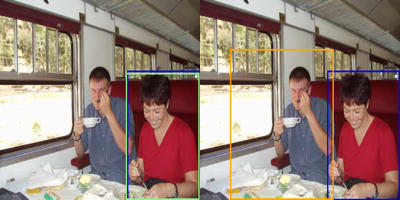

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL.
window to right of tree


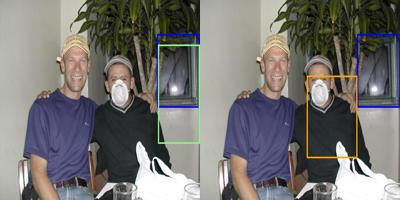

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL.
the plant in front of the animal


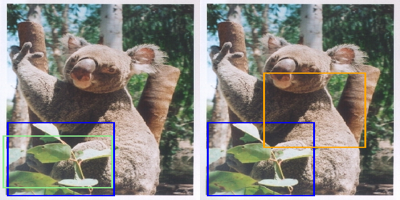

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL.
patch of road on the left side


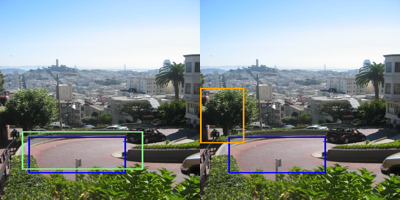

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL.
hat on guy on left


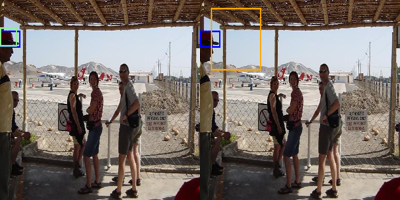

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL.
mountain on right just below skyline


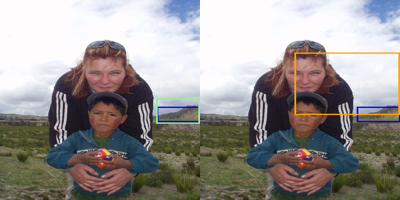

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL.
water to left of left most tree


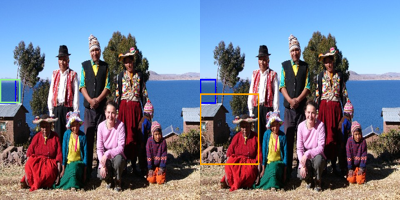

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL.
person in grey with a black bag


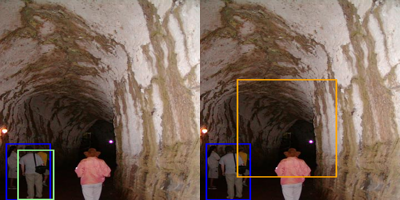

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL.
green food in dish


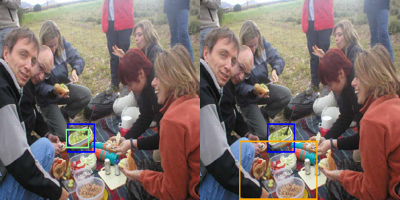

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL.
lady in the bikini


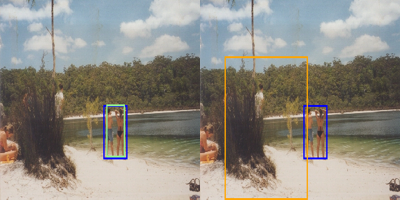

In [16]:
df = df_situation_1.query("relational == 1")
resize_tuple = (200, 200)
df_sample_cls = df.query("0 < iou_005 <= 0.1")
df_sample_cls = df_sample_cls.sample(min(10, df_sample_cls.shape[0]), random_state=77)
for _, row in df_sample_cls.loc[:, ["bbox_raw", "bbox_pred_003", "bbox_pred_005", "img_filename", "expr"]].iterrows():
    im = Image.open(f"{BASE_PATH}{row['img_filename']}")
    im = draw_bounding_boxes(im, [row['bbox_raw']], fmt="xyxy", color="blue", line_width=3)
    im2 = im.copy()
    im = draw_bounding_boxes(im, [row['bbox_pred_003']], fmt="xyxy", color="lightgreen", line_width=3)
    im2 = draw_bounding_boxes(im2, [row['bbox_pred_005']], fmt="xyxy", color="orange", line_width=3)
    im = im.resize(resize_tuple)
    im2 = im2.resize(resize_tuple)
    print(f"exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL.")
    print(row['expr'])
    get_concat_h(im, im2).show()

In [17]:
df_situation_2 = df_preds_val_sub.query("hits_50_003 == 1 and hits_50_005 == 1").reset_index(drop=True)

In [18]:
df_situation_2.query("relational == 1").loc[:, ["spatial", "relational", "ordinal", "intrinsic"]].sum()

spatial       162
relational    162
ordinal         2
intrinsic       0
dtype: int64

In [19]:
df_situation_2.query("spatial == 1").loc[:, ["spatial", "relational", "ordinal", "intrinsic"]].sum()

spatial       889
relational    162
ordinal         5
intrinsic       0
dtype: int64

In [21]:
df_situation_2.query("relational == 1").iou_005.describe([.65,.75,.80,.85,.90,.95])

count    162.000000
mean       0.666199
std        0.117806
min        0.500221
50%        0.638839
65%        0.724386
75%        0.756763
80%        0.787993
85%        0.800704
90%        0.831840
95%        0.876234
max        0.977309
Name: iou_005, dtype: float64

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL (also SPATIAL).
grass on bottom of photo


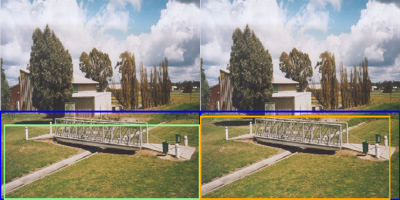

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL (also SPATIAL).
wall on top part of pic


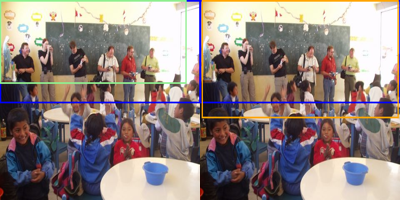

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL (also SPATIAL).
wall above/behind people


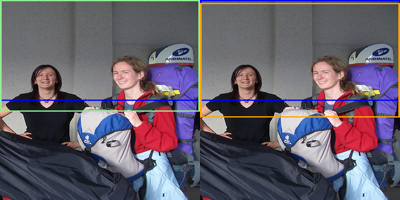

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL (also SPATIAL).
group of peoples on bottom left


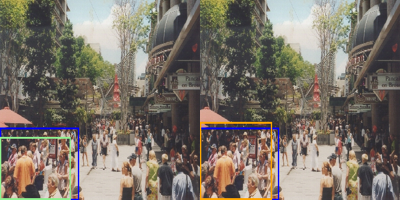

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL (also SPATIAL).
sky above bald man 's head


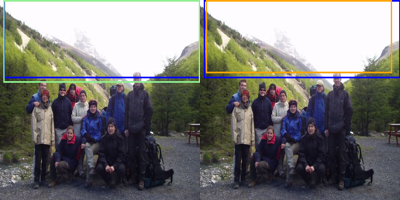

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL (also SPATIAL).
sand under chair


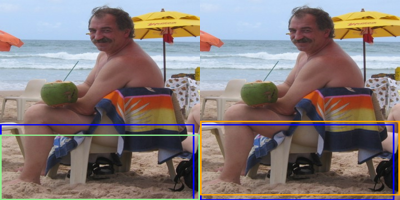

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL (also SPATIAL).
sky above person


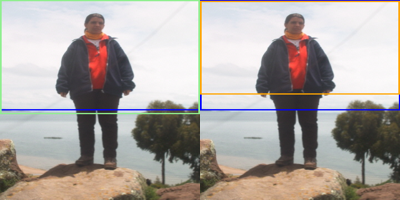

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL (also SPATIAL).
lol either wall on the left/right but only the tops


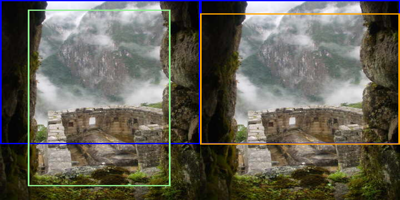

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL (also SPATIAL).
rocks under sky


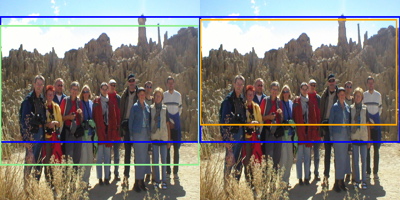

exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL (also SPATIAL).
sand in front of pic


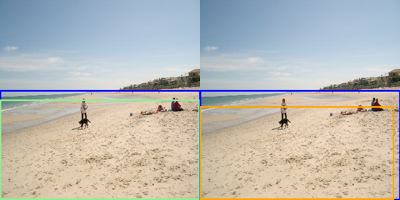

In [27]:
df = df_situation_2.query("relational == 1")
resize_tuple = (200, 200)
df_sample_cls = df.query("0.8 < iou_005 <= 1")
df_sample_cls = df_sample_cls.sample(min(10, df_sample_cls.shape[0]), random_state=42)
for _, row in df_sample_cls.loc[:, ["bbox_raw", "bbox_pred_003", "bbox_pred_005", "img_filename", "expr"]].iterrows():
    im = Image.open(f"{BASE_PATH}{row['img_filename']}")
    im = draw_bounding_boxes(im, [row['bbox_raw']], fmt="xyxy", color="blue", line_width=3)
    im2 = im.copy()
    im = draw_bounding_boxes(im, [row['bbox_pred_003']], fmt="xyxy", color="lightgreen", line_width=3)
    im2 = draw_bounding_boxes(im2, [row['bbox_pred_005']], fmt="xyxy", color="orange", line_width=3)
    im = im.resize(resize_tuple)
    im2 = im2.resize(resize_tuple)
    print(f"exp003 (left, green) and exp005 (right, orange) comparision. RELATIONAL (also SPATIAL).")
    print(row['expr'])
    get_concat_h(im, im2).show()

exp003 (left, green) and exp005 (right, orange) comparision. SPATIAL PURE.
ground


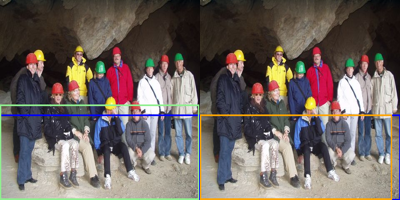

exp003 (left, green) and exp005 (right, orange) comparision. SPATIAL PURE.
ground area


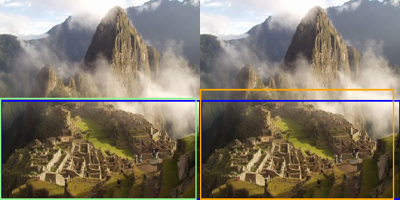

exp003 (left, green) and exp005 (right, orange) comparision. SPATIAL PURE.
trees on the bottom


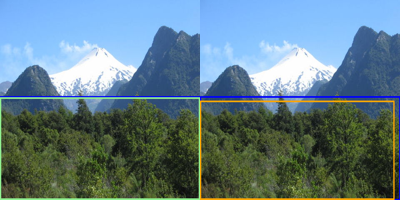

exp003 (left, green) and exp005 (right, orange) comparision. SPATIAL PURE.
any part of the sky but dont you dare touch a cloud


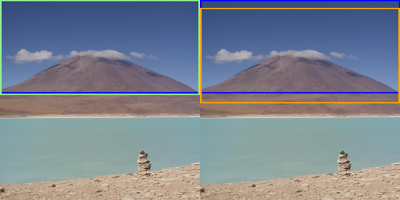

exp003 (left, green) and exp005 (right, orange) comparision. SPATIAL PURE.
city middle


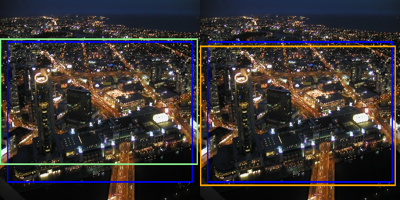

exp003 (left, green) and exp005 (right, orange) comparision. SPATIAL PURE.
roof top


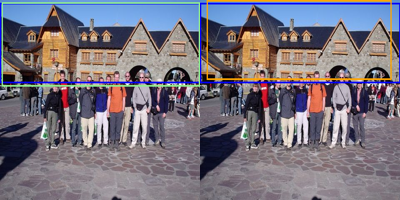

exp003 (left, green) and exp005 (right, orange) comparision. SPATIAL PURE.
anywhere on the kid


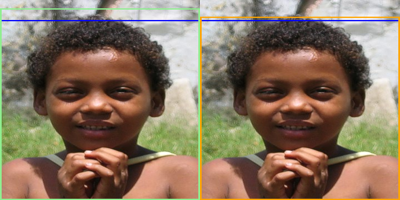

exp003 (left, green) and exp005 (right, orange) comparision. SPATIAL PURE.
anywhere in the pic


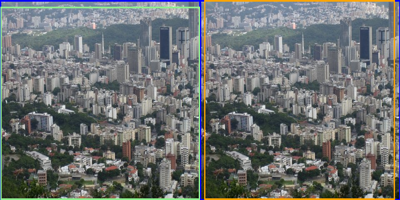

exp003 (left, green) and exp005 (right, orange) comparision. SPATIAL PURE.
any of the rocks


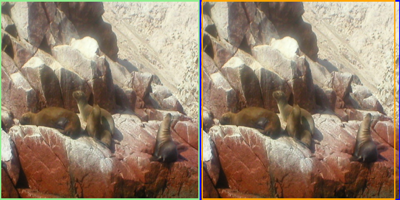

exp003 (left, green) and exp005 (right, orange) comparision. SPATIAL PURE.
bottom anywhere


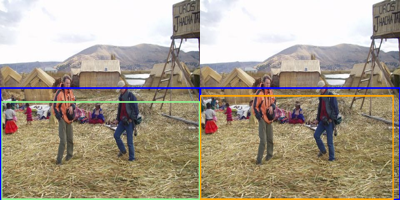

In [26]:
df = df_situation_2.query("spatial == 1 and relational == 0 and ordinal == 0")
resize_tuple = (200, 200)
df_sample_cls = df.query("0.8 < iou_005 <= 1")
df_sample_cls = df_sample_cls.sample(min(10, df_sample_cls.shape[0]), random_state=77)
for _, row in df_sample_cls.loc[:, ["bbox_raw", "bbox_pred_003", "bbox_pred_005", "img_filename", "expr"]].iterrows():
    im = Image.open(f"{BASE_PATH}{row['img_filename']}")
    im = draw_bounding_boxes(im, [row['bbox_raw']], fmt="xyxy", color="blue", line_width=3)
    im2 = im.copy()
    im = draw_bounding_boxes(im, [row['bbox_pred_003']], fmt="xyxy", color="lightgreen", line_width=3)
    im2 = draw_bounding_boxes(im2, [row['bbox_pred_005']], fmt="xyxy", color="orange", line_width=3)
    im = im.resize(resize_tuple)
    im2 = im2.resize(resize_tuple)
    print(f"exp003 (left, green) and exp005 (right, orange) comparision. SPATIAL PURE.")
    print(row['expr'])
    get_concat_h(im, im2).show()

Preliminary results after the above observation:

1A: seems like the only-text model can identify left, right, etc, no matter if it does not have visual information. It may contains info regarding which side the bbox should be predicted.

2A: seems like the model only needs references like left, bottom left, etc. The size of the bounding boxes are quite similar, and most of the examples contain big ground truth and big predicted bounding boxes. An example we can discuss is the "group of peoples on bottom left". It's a small predicted bounding box (as small as the ground truth), but maybe the "bottom left" tells the model to predict a small bbox instead of a big one.


To validate the hypotheses, we should load the model and then predict again with more or less information in these examples. Predict and then compare the iou again.